In [202]:
#Primero importamos las paqueterias principales, decidi trabajar en Jupyter Notebook ya que
#facilita en gran medida explicar el funcionamiento del modelo.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa

In [203]:
#Abrimos los archivos parquet con los datos, para esto es necesario importar pandas y la libreia pyarrow de Apache Spark.

cli=pd.read_parquet('./0clientes.parquet') #Archivo con informacion de los clientes.
sal=pd.read_parquet('./0saldos.parquet')   #Archivo con los saldos por cliente, contrato y producto.
tran=pd.read_parquet('./0transferencias.parquet')  #Archivo con aportaciones y retiros por contrato y producto.


In [204]:
#Vectorizamos los valores en los campos de 'CIUDAD', 'EnvioExtractos' y 'TIPODOCUM' del archivo de clientes. 
vec_ciudad=cli['CIUDAD'].unique()
vec_et=cli['EnvioExtractos'].unique()
vec_doc=cli['TIPODOCUM'].unique()

#Creamos funciones para asignar un codigo correspondiente a la 'CIUDAD', 'EnvioExtractos' y 'TIPODOCUM' del archivo de clientes.

def asignar_codigo_ciudad(ciudad):
    index=np.where(vec_ciudad==ciudad)
    return index[0][0]

def asignar_codigo_envioextracto(et):
    index=np.where(vec_et==et)
    return index[0][0]

def asignar_codigo_doc(doc):
    index=np.where(vec_doc==doc)
    return index[0][0]

    

In [205]:
#Aplicamos las funciones a cada uno de los campos del archivo, esto con la finalidad de que el modelo
#pueda tomar estos datos en consideracion.

cli["CIUDAD"]=cli["CIUDAD"].apply(asignar_codigo_ciudad)
cli['EnvioExtractos']=cli['EnvioExtractos'].apply(asignar_codigo_envioextracto)
cli['TIPODOCUM']=cli['TIPODOCUM'].apply(asignar_codigo_doc)

In [206]:
cli['FecNacim']=cli['FecNacim'].astype('int64')/10**9 #Transformamos la fecha de nacimiento a tipo numerico.

In [207]:
sal=sal.drop(['TipoDocum'],axis=1) #Eliminamos el campo 'TipoDocum' del archivo con los saldos ya que
                                   #ya lo consideramos en el archivo de clientes.

In [208]:
sal.head() #Observamos el archivo con los saldos.

,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,SALDO_202110,...,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202209,SALDO_202210,Contrato,PlanProducto,NroDocum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1921905,3376,1041211502
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9441003,3376,1079794076
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4580954,1722,1125051788
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3549161,3376,1197460465
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6619455,3376,1081082256


In [209]:
tran=tran.loc[:,['FechaEfectiva','ValorNeto','Contrato','PlanProducto']] #Tomamos solo los campos que nos interesan del 
                                                                         #archivo con aportaciones y retiros.

In [210]:
#Creamos un campo en el dataframe de aportaciones y retiros que nos indique durante que periodo se hizo el movimiento.

tran['month']=tran['FechaEfectiva'].dt.month
tran['year']=tran['FechaEfectiva'].dt.year
tran['Periodo']=tran['month'].astype(str)+'/'+tran['year'].astype(str)

In [211]:
tran

,FechaEfectiva,ValorNeto,Contrato,PlanProducto,month,year,Periodo
0,2021-07-27,-7921800.0,8774634,7256,7,2021,7/2021
1,2021-07-27,-7850000.0,8774634,7256,7,2021,7/2021
2,2021-07-28,-6000000.0,8774634,7256,7,2021,7/2021
3,2021-07-28,-8000000.0,8774634,7256,7,2021,7/2021
4,2021-07-22,-8256019.0,8774634,7256,7,2021,7/2021
...,...,...,...,...,...,...,...
491825,2022-09-23,-5000000.0,7678955,7256,9,2022,9/2022
491826,2022-09-23,-20000000.0,6916388,5172,9,2022,9/2022
491827,2022-09-23,-24000000.0,3107778,7256,9,2022,9/2022
491828,2022-09-23,100000000.0,8688704,5172,9,2022,9/2022


In [212]:
tran=tran.drop(['FechaEfectiva','PlanProducto','month','year'],axis=1) #Eliminamos campos innecesarios.

In [213]:
tran

,ValorNeto,Contrato,Periodo
0,-7921800.0,8774634,7/2021
1,-7850000.0,8774634,7/2021
2,-6000000.0,8774634,7/2021
3,-8000000.0,8774634,7/2021
4,-8256019.0,8774634,7/2021
...,...,...,...
491825,-5000000.0,7678955,9/2022
491826,-20000000.0,6916388,9/2022
491827,-24000000.0,3107778,9/2022
491828,100000000.0,8688704,9/2022


In [214]:
tran=tran.sort_values(by=['Periodo']) #Ordenamos los movimientos considerando en que periodo se realizaron.
tran

,ValorNeto,Contrato,Periodo
70286,-89995.0,8774634,1/2009
319451,15300.0,3727990,1/2017
11956,-2000000.0,8774634,1/2018
471666,8000000.0,1752724,1/2019
491319,7450000.0,182400,1/2019
...,...,...,...
134446,-500000.0,8774634,9/2022
478067,-5000000.0,7816790,9/2022
387896,3000000.0,7492469,9/2022
301009,122250.0,6911476,9/2022


In [215]:
#Esta operacion es muy importante: aqui sumamos todos los retiros y depositos de cada periodo y de cada contrato.
tran=tran.groupby(['Contrato','Periodo']).sum()

In [216]:
t=tran.pivot_table('ValorNeto',['Contrato'],'Periodo') #Le damos el formato necesario al dataframe.

In [217]:
t

Periodo,1/2009,1/2017,1/2018,1/2019,1/2020,1/2021,1/2022,10/2016,10/2018,10/2019,...,8/2022,9/2007,9/2010,9/2012,9/2016,9/2018,9/2019,9/2020,9/2021,9/2022
Contrato,,,,,,,,,,,,,,,,,,,,,
10359,NaN,NaN,NaN,NaN,NaN,10000000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11595,NaN,NaN,NaN,NaN,NaN,5200000.0,5200000.0,NaN,NaN,NaN,...,5200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5200000.0,5200000.0
11989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
t.fillna(0, inplace=True) #Si cierta cuenta no tuvo movimientos en algun periodo, le asignamos un 0.

In [219]:
t

Periodo,1/2009,1/2017,1/2018,1/2019,1/2020,1/2021,1/2022,10/2016,10/2018,10/2019,...,8/2022,9/2007,9/2010,9/2012,9/2016,9/2018,9/2019,9/2020,9/2021,9/2022
Contrato,,,,,,,,,,,,,,,,,,,,,
10359,0.0,0.0,0.0,0.0,0.0,10000000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11595,0.0,0.0,0.0,0.0,0.0,5200000.0,5200000.0,0.0,0.0,0.0,...,5200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5200000.0,5200000.0
11989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9999584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9999852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
sal=sal.groupby(['NroDocum','Contrato']).sum().reset_index() #Sumamos el total de saldos por cliente y por contrato, no nos
                                                             #interesa hacerlo por producto ya que el modelo funciona a nivel
                                                             #cliente, pero si necesitamos el campo de contrato para unir el 
                                                             #dataframe de saldos con el dataframe de retiros y aportaciones.

In [221]:
sal=sal.drop(['PlanProducto'],axis=1) #Eliminamos el campo de producto.

In [222]:
sal

,NroDocum,Contrato,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,...,SALDO_202201,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202209,SALDO_202210
0,1000001634,9950268,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,46923569.02,51736105.43,50861586.44,...,49995410.98,50906994.84,48238571.01,50249882.12,48430969.50,48976166.48,50399995.40,49148602.10,0.0,49674978.39
1,1000004345,5919728,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
2,1000004345,6133677,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
3,1000004345,6261343,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
4,1000004345,8629082,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201053,1199993307,1289932,2.856972e+08,2.730600e+08,2.673612e+08,2.204067e+08,1.204125e+08,46956084.98,26929880.92,27093625.77,...,8987907.79,8968533.18,8961261.50,970182.65,267835.63,266591.86,264048.45,265316.21,0.0,266610.62
201054,1199993307,7107200,1.247460e+04,1.238464e+04,1.206761e+04,1.217294e+04,1.210377e+04,12186.97,12173.03,12344.29,...,12220.41,12078.93,12084.99,11874.11,11707.25,11331.27,11069.06,11165.31,0.0,10880.66
201055,1199997482,476487,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
201056,1199997722,5692800,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


In [223]:
#Unimos los dataframes de clientes y saldos con el campo 'NroDocum'.
cli_sal=cli.merge(sal,how='outer',left_on='NroDocum',right_on='NroDocum') 

In [224]:
cli_sal.fillna(0,inplace=True) #LLenamos los datos faltantes con ceros.

In [225]:
cli_sal

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,NroDocum,Contrato,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,...,SALDO_202201,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202209,SALDO_202210
0,0.0,0.0,-8294400.0,0.0,1000001634,9950268,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,...,49995410.98,50906994.84,48238571.01,50249882.12,48430969.50,48976166.48,50399995.40,49148602.10,0.0,49674978.39
1,0.0,0.0,-584582400.0,1.0,1000004345,5919728,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
2,0.0,0.0,-584582400.0,1.0,1000004345,6133677,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
3,0.0,0.0,-584582400.0,1.0,1000004345,6261343,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
4,0.0,0.0,-584582400.0,1.0,1000004345,8629082,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201123,0.0,14.0,-311472000.0,0.0,1199993307,1289932,2.856972e+08,2.730600e+08,2.673612e+08,2.204067e+08,...,8987907.79,8968533.18,8961261.50,970182.65,267835.63,266591.86,264048.45,265316.21,0.0,266610.62
201124,0.0,14.0,-311472000.0,0.0,1199993307,7107200,1.247460e+04,1.238464e+04,1.206761e+04,1.217294e+04,...,12220.41,12078.93,12084.99,11874.11,11707.25,11331.27,11069.06,11165.31,0.0,10880.66
201125,0.0,0.0,211852800.0,0.0,1199997482,476487,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
201126,0.0,0.0,-557625600.0,1.0,1199997722,5692800,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


In [226]:
#Unimos los 3 dataframes con el campo 'Contrato'.
cli_sal_t=cli_sal.merge(t,how='outer',left_on='Contrato',right_on='Contrato')

In [227]:
cli_sal_t.fillna(0,inplace=True) #Llenamos los datos faltantes con ceros.

In [228]:
cli_sal_t

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,NroDocum,Contrato,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,...,8/2022,9/2007,9/2010,9/2012,9/2016,9/2018,9/2019,9/2020,9/2021,9/2022
0,0.0,15.0,130464000.0,1.0,1184755661,10098,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-547171200.0,1.0,1036202838,10103,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,305337600.0,0.0,1039603374,10148,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,7.0,69984000.0,0.0,1115021901,10280,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,28771200.0,2.0,1022669639,10300,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201123,0.0,0.0,-97632000.0,0.0,1084149110,9999884,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201124,0.0,3.0,32659200.0,0.0,1020019654,9999898,1.981584e+08,1.982906e+08,1.973628e+08,1.977829e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,0.0
201125,0.0,0.0,-931651200.0,1.0,1019831767,9999908,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201126,0.0,0.0,30844800.0,0.0,1082986038,9999924,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
#Finalmente, eliminamos el campo 'Contrato' y sumamos el total de saldos y movimientos por cliente ('NroDocum').

data=cli_sal_t.drop(['Contrato'],axis=1).groupby(['NroDocum']).sum()

In [230]:
data

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,...,8/2022,9/2007,9/2010,9/2012,9/2016,9/2018,9/2019,9/2020,9/2021,9/2022
NroDocum,,,,,,,,,,,,,,,,,,,,,
1000001634,0.0,0.0,-8.294400e+06,0.0,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,...,-600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-600000.0,-600000.0
1000004345,0.0,0.0,-2.922912e+09,5.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000005362,0.0,0.0,-1.534810e+09,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000005396,0.0,0.0,2.044224e+08,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000007479,0.0,0.0,-2.992896e+08,0.0,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,...,3000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000000.0,202235748.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199993065,0.0,1.0,2.635200e+07,0.0,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,...,-2610000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8178000.0
1199993307,0.0,28.0,-6.229440e+08,0.0,2.857097e+08,2.730724e+08,2.673733e+08,2.204188e+08,1.204246e+08,4.696827e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1000000.0,0.0
1199997482,0.0,0.0,2.118528e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
#Definimos una funcion para determinar si un cliente retiro mas del 70% de su saldo en los ultimos tres meses.
#La funcion retorna 1 si lo hizo y 0 si no.
def retira(sal0,sal1,sal2,sal3):
    return ((sal1<sal0*0.3) | (sal2<sal0*0.3) | (sal3<sal0*0.3))*1
    

In [232]:
#Aplicamos la funcion al dataframe para asignarle una etiqueta a cada cliente.
data['Label']=retira(data['SALDO_202207'],data['SALDO_202208'],data['SALDO_202209'],data['SALDO_202210'])

In [233]:
data

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,...,9/2007,9/2010,9/2012,9/2016,9/2018,9/2019,9/2020,9/2021,9/2022,Label
NroDocum,,,,,,,,,,,,,,,,,,,,,
1000001634,0.0,0.0,-8.294400e+06,0.0,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-600000.0,-600000.0,1
1000004345,0.0,0.0,-2.922912e+09,5.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1000005362,0.0,0.0,-1.534810e+09,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1000005396,0.0,0.0,2.044224e+08,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1000007479,0.0,0.0,-2.992896e+08,0.0,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000000.0,202235748.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199993065,0.0,1.0,2.635200e+07,0.0,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8178000.0,1
1199993307,0.0,28.0,-6.229440e+08,0.0,2.857097e+08,2.730724e+08,2.673733e+08,2.204188e+08,1.204246e+08,4.696827e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1000000.0,0.0,1
1199997482,0.0,0.0,2.118528e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [234]:
data['Label'] #Etiquetas asignadas a cada cliente

NroDocum
1000001634    1
1000004345    0
1000005362    0
1000005396    0
1000007479    1
             ..
1199993065    1
1199993307    1
1199997482    0
1199997722    0
1199999288    0
Name: Label, Length: 108074, dtype: int32

In [235]:
sum(data['Label'])/len(data) #Observamos que alrededor del 23% de los clientes retiraron mas del 70% de su saldo
                             #en los ultimos 3 meses.

0.23130447656235542

In [236]:
shuffled_data=data.sample(frac=1) #Revolvemos los datos.

In [237]:
#Dividimos los datos para entrenamiento y validacion.
#El 70% de los datos seran utilizados para entrenamiento y el resto para validacion.

train=shuffled_data.iloc[:int(0.7*len(data)),:] 
test=shuffled_data.iloc[int(0.7*len(data)):,:]

In [238]:
x_train=train.drop(['Label','SALDO_202208','SALDO_202209','SALDO_202210'],axis=1) #Eliminamos los campos objetivo de los datos de entrenamiento.
y_train=train['Label'] #Dataframe con las etiquetas objetivo para entrenamiento.

In [239]:
x_test=test.drop(['Label','SALDO_202208','SALDO_202209','SALDO_202210'],axis=1) #Eliminamos los campos objetivo de los datos de validacion.
y_test=test['Label'] #Dataframe con las etiquetas objetivo para la validacion.

In [240]:
#Importamos las librerias necesarias para el escalado de los datos, para el diseno del modelo, y para el analisis de su desempeno.

#Aunque se puede disenar un modelo mas sofisticado utilizando tensorflow o pytorch, por ejemplo, el modelo
#de regresion logistica proporcionado por scikit-learn mostro ser suficiente para nuestro caso.

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics

In [241]:
#Esta funcion se encarga de definir el modelo, entrenarlo y mostrar su desempeno.

#El modelo utiliza un algoritmo de regresion logistica para clasificar a los clientes en dos categorias considerando
#la probabilidad que tienen de retirar mas del 70% de su saldo en los proximos 6 meses.

def model(scaler,xtrain,ytrain,xtest,ytest,iter=3000):
    pipe=make_pipeline(scaler,LogisticRegression(max_iter=iter)) #Hacemos un pipeline para escalar los datos antes de ingresarlos al modelo.
    pipe.fit(xtrain,ytrain) #Entrenamos el modelo
    print('Score=',pipe.score(xtest,ytest)) #Imprimimos el Score del modelo (Coeficiente de determinacion R^2).
    y_pred=pipe.predict(xtest) #Predicciones utilizando los datos de validacion.
    cm=metrics.confusion_matrix(ytest,y_pred) #Matriz de confusion.
    print('Confusion matrix=',cm)
    names=['No retira mas del 70 %','Retira mas del 70 %']
    print(metrics.classification_report(ytest,y_pred,target_names=names)) #Metricas del modelo.
    return pipe


In [242]:
model=model(StandardScaler(), x_train, y_train, x_test, y_test, iter=3000)

Score= 0.9220614995527866
Confusion matrix= [[24854    22]
 [ 2505  5042]]
                        precision    recall  f1-score   support

No retira mas del 70 %       0.91      1.00      0.95     24876
   Retira mas del 70 %       1.00      0.67      0.80      7547

              accuracy                           0.92     32423
             macro avg       0.95      0.83      0.88     32423
          weighted avg       0.93      0.92      0.92     32423



Podemos observar que el modelo tiene un desempeno muy bueno, con un accuracy general de 92%, esto nos dice que el modelo clasifica correctamente en el 92% de los casos.

La presicion y el f1-score tambien son bastante altos, lo que indica un gran desempeno en general. Lo mas notable que tiene una muy alta precision detectanto los casos en los que el cliente retirara mas del 70% de su saldo, aunque un recall no muy alto, que aunque no es malo, podria ser mejor. Esto nos indica que es un modelo excelente cuando queremos evitar los falsos positivos a toda costa, mientras no haya mucho problema que detectemos falsos negativos, lo cual, me parece, es nuestro caso.



In [245]:
def plot_roc(model,x_test,y_test):
    proba=model.predict_proba(x_test)[::,1]
    fpr, tpr, _=metrics.roc_curve(y_test,proba)
    auc=metrics.roc_auc_score(y_test, proba)
    plt.plot(fpr,tpr,label='AUC='+str(auc))
    plt.legend(loc=4)
    plt.show()

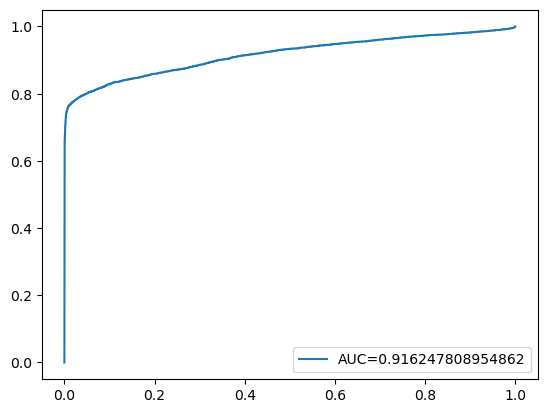

In [246]:
plot_roc(model,x_test,y_test)

La curva ROC nos confirma el buen desempeno del modelo al mostrarnos un AUC de 0.91.

In [247]:
model.predict_proba(x_test) #Por ultimo, se utiliza este metodo para obtener las probabilidades de que cada cliente retire mas del 
                        	#70% de su saldo.

array([[0.89802854, 0.10197146],
       [0.91829383, 0.08170617],
       [0.92149897, 0.07850103],
       ...,
       [0.90609591, 0.09390409],
       [0.47207232, 0.52792768],
       [0.9267246 , 0.0732754 ]])